In [245]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt

In [212]:
% matplotlib inline

In [1380]:
class Gaussian_Process():
    
    def __init__(self, kernel):
        self.kernel = kernel
        self.gp = GaussianProcessRegressor(kernel=kernel,
                                           optimizer = None,
                                           n_restarts_optimizer=10,
                                           normalize_y=True)
    
    def optimise__with_splice_sampling(self, initial_theta, num_iters, sigma, burn_in,  X, y):
        self.fit(X, y)
        slice_sampler = Slice_sampler(num_iters = num_iters, 
                                      sigma = sigma, 
                                      burn_in = burn_in,
                                      gp = self)
        samples = slice_sampler.sample(init = initial_theta)
        theta_opt = [np.mean(samples[0]),np.mean(samples[1])]
        
        self.gp.set_params(**{"kernel__k1__length_scale": np.mean(samples[0]),
                            "kernel__k2__noise_level": np.power(np.mean(samples[0]),2)})
    
    
        
    def log_marginal_likelihood(self,theta):
        return self.gp.log_marginal_likelihood(theta)
    
    def log_prior_parameters(self, theta):
        return np.sum(np.log([ss.norm(0, 1).pdf(theta_k) for theta_k in theta]))
    
    def log_joint_unnorm(self, theta):
        return self.log_marginal_likelihood(theta) + self.log_prior_parameters(theta)
        
    def fit(self, X, y):
        self.gp.fit(X, y)
    
    def predict(self, X):
        mu, sigma = self.gp.predict(X, return_std=True)
        return mu, sigma

In [1381]:
class Slice_sampler():
    
    def __init__(self, num_iters, sigma, burn_in, gp):
        self.num_iters = num_iters
        self.sigma = sigma
        self.burn_in = burn_in
        self.gp = gp
        
    def sample(self, init, step_out=True):

        D = len(init)
        samples = np.zeros((D, self.num_iters))
        
        xx = init.copy()

        for i in xrange(self.num_iters + self.burn_in):
            perm = range(D)
            np.random.shuffle(perm)
            last_llh = self.gp.log_joint_unnorm(xx)

            for d in perm:
                llh0 = last_llh + np.log(np.random.rand())
                rr = np.random.rand(1)
                x_l = xx.copy()
                x_l[d] = x_l[d] - rr * self.sigma[d]
                x_r = xx.copy()
                x_r[d] = x_r[d] + (1 - rr) * self.sigma[d]

                if step_out:
                    llh_l = self.gp.log_joint_unnorm(x_l)
                    while llh_l > llh0:
                        x_l[d] = x_l[d] - self.sigma[d]
                        llh_l = self.gp.log_joint_unnorm(x_l)
                    llh_r = self.gp.log_joint_unnorm(x_r)
                    while llh_r > llh0:
                        x_r[d] = x_r[d] + self.sigma[d]
                        llh_r = self.gp.log_joint_unnorm(x_r)

                x_cur = xx.copy()
                while True:
                    xd = np.array(np.random.rand() * (x_r[d] - x_l[d]) + x_l[d])
                    x_cur[d] = xd.copy()
                    last_llh = self.gp.log_joint_unnorm(x_cur)
                    if last_llh > llh0:
                        xx[d] = xd.copy()
                        break
                    elif xd > xx[d]:
                        x_r[d] = xd
                    elif xd < xx[d]:
                        x_l[d] = xd
                    else:
                        raise RuntimeError('Slice sampler shrank too far.')
                
            if i == 0:
                print "burn-in"
            elif i > self.burn_in and i % 100 == 0: 
                print 'iteration', i - self.burn_in
            
            if i > self.burn_in:   
                samples[:, i-self.burn_in] = xx.copy().ravel()
        
        #plt.hist(samples[0])

        return samples

In [1390]:
X_train = np.linspace(-5,5,50)
y_train = np.sin(X) + np.random.normal(loc = 0, scale = 0.5,size=50)

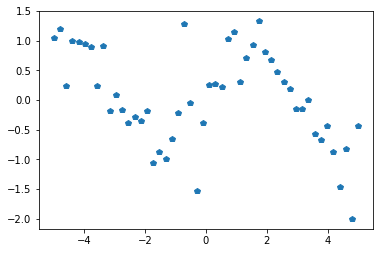

In [1391]:
plt.plot(X_train, y_train, "p")

In [1383]:
kernel = kernels.Sum(kernels.Matern(), kernels.WhiteKernel())
gp = Gaussian_Process(kernel = kernel)

In [1392]:
gp.optimise__with_splice_sampling(initial_theta = np.array([1.,1.]),
                                  num_iters = 1000,
                                  sigma = np.array([1.,1.]),
                                  burn_in = 200,
                                  X = X_train.reshape(-1, 1),
                                  y = y_train)

burn-in
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900


In [1373]:
gp.fit(X_train.reshape(-1, 1), y_train)

In [1385]:
X_test = np.linspace(-10,10,100)
mu, sigma = gp.predict(X_test.reshape(-1, 1))

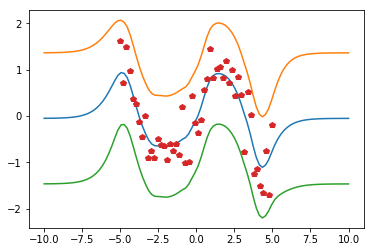

In [1386]:
plt.plot(X_test, mu)
plt.plot(X_test, mu+sigma)
plt.plot(X_test, mu-sigma)
plt.plot(X, y, "p")